## IMPORTACIÓN LIBRERIAS

In [1]:
import numpy as np
import pandas as pd
from math import *
import math
import matplotlib.pyplot as plt
# from PIL import Image
import seaborn as sns
# import itertools
# import io 
# import plotly.offline as py
#py.init_notebook_mode(connect=True)
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots
# import plotly.figure_factory as ff
import warnings
warnings.filterwarnings('ignore')

## CARGAR ARCHIVOS

In [2]:
def load_dataset(file_path, file_type=None, separator=None, encoding='utf-8', **kwargs):
    """
    Loads a dataset in different formats, with support for custom separators, encoding, and more options.
    """
    # If the file type is not specified, infer from file extension
    if not file_type:
        file_type = file_path.split('.')[-1].lower()

    # Load according to the file type
    if file_type == 'csv':
        return pd.read_csv(file_path, sep=separator or ',', encoding=encoding, **kwargs)
    elif file_type in ['xls', 'xlsx']:
        return pd.read_excel(file_path, **kwargs)
    elif file_type == 'json':
        return pd.read_json(file_path, encoding=encoding, **kwargs)
    else:
        raise ValueError(f"File format '{file_type}' not supported. Use 'csv', 'excel', or 'json'.")

In [4]:
accesos24 = load_dataset('../data/Accessos 2024.xlsx')
accesos = load_dataset('../data/Copia de Accessos 01.01.2025 a 30.04.2025.xlsx')
accesos2 = load_dataset('../data/Copia de Accessos 01.05.2025 a 31.07.2025.xlsx')
accesos3 = load_dataset('../data/Copia de Accessos 01.08.2025 a 01.09.2025.xlsx')

Concatenamos los diferentes archivos en uno solo

In [5]:
#Concatenar los tres dataframes en uno solo
accesos_total = pd.concat([accesos24, accesos, accesos2, accesos3], ignore_index=True)
accesos_total

,IdPersona,Año,Mes,Dia,HEntrada,HSalida,HoraEntrada,HoraSalida
0,334,2024,9,10,10.0,11.0,10:51:48,11:32:57
1,334,2024,9,12,11.0,12.0,11:47:06,12:35:12
2,334,2024,9,17,10.0,11.0,10:48:53,11:50:54
3,2926,2024,10,24,15.0,15.0,15:24:59,15:43:37
4,2926,2024,11,7,11.0,13.0,11:20:52,13:37:48
...,...,...,...,...,...,...,...,...
213735,117358,2025,9,1,17.0,17.0,17:21:12,17:23:30
213736,117358,2025,9,1,18.0,19.0,18:00:35,19:10:51
213737,117360,2025,9,1,17.0,18.0,17:32:58,18:43:41
213738,117375,2025,9,1,18.0,19.0,18:58:55,19:17:02


## DEA

In [6]:
df_accesos= accesos_total.copy()

In [7]:
df_accesos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213740 entries, 0 to 213739
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   IdPersona    213740 non-null  int64  
 1   Año          213740 non-null  int64  
 2   Mes          213740 non-null  int64  
 3   Dia          213740 non-null  int64  
 4   HEntrada     213319 non-null  float64
 5   HSalida      213565 non-null  float64
 6   HoraEntrada  213740 non-null  object 
 7   HoraSalida   213740 non-null  object 
dtypes: float64(2), int64(4), object(2)
memory usage: 13.0+ MB


#### ¿Hay nulos?


📌 Variables with missing values:


,Total Missing,Percentage Missing
HEntrada,421,0.196968
HSalida,175,0.081875


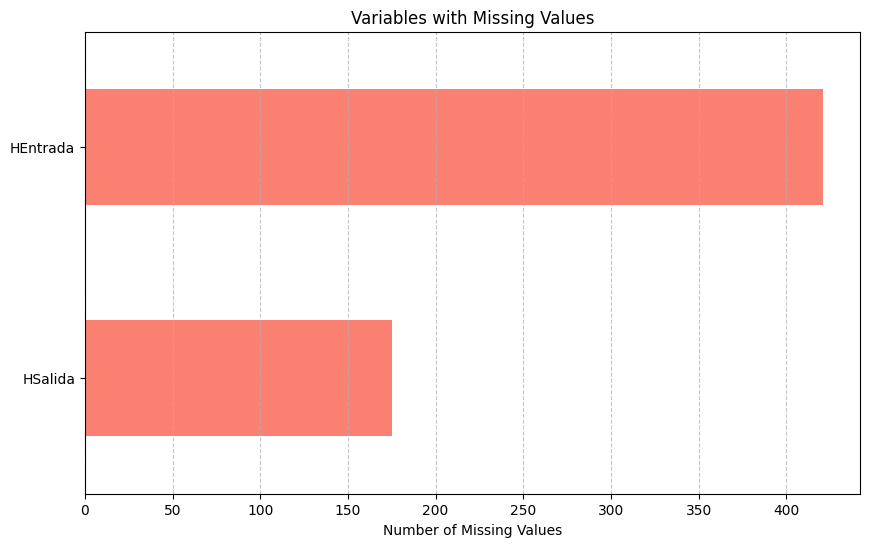

In [9]:
# 4. Variables with missing values
    # Detect columns with missing values and show the percentage
print("\n📌 Variables with missing values:")

# Count missing values by column
missing = df_accesos.isnull().sum()

# Filter only columns with missing values
missing = missing[missing > 0].sort_values(ascending=False)

# Calculate missing percentage
missing_percentage = (missing / len(df_accesos)) * 100

# Create a DataFrame to show the count and percentage of missing values
missing_df = pd.DataFrame({'Total Missing': missing, 'Percentage Missing': missing_percentage})

# If missing values exist, display a bar chart of missing values distribution
if not missing.empty:
    display(missing_df)
    plt.figure(figsize=(10, 6))
    missing.plot(kind='barh', color='salmon')  # Horizontal bar chart
    plt.title("Variables with Missing Values")
    plt.xlabel("Number of Missing Values")
    plt.gca().invert_yaxis()  # Invert y-axis to show variables with most missing values first
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)  # Add grid to the chart
    plt.show()
else:
    print("✅ No missing values in the dataset.")


Al observar el resultado, decidimos eliminar las dos columnas con valores nulos, ya que en otras columnas ya aporta la misma información.

In [11]:

df_accesos= df_accesos.drop(columns=['HEntrada', 'HSalida'])
df_accesos

,IdPersona,Año,Mes,Dia,HoraEntrada,HoraSalida
0,334,2024,9,10,10:51:48,11:32:57
1,334,2024,9,12,11:47:06,12:35:12
2,334,2024,9,17,10:48:53,11:50:54
3,2926,2024,10,24,15:24:59,15:43:37
4,2926,2024,11,7,11:20:52,13:37:48
...,...,...,...,...,...,...
213735,117358,2025,9,1,17:21:12,17:23:30
213736,117358,2025,9,1,18:00:35,19:10:51
213737,117360,2025,9,1,17:32:58,18:43:41
213738,117375,2025,9,1,18:58:55,19:17:02


#### - TRATAMIENTO DE FECHA DE ACCESO

In [12]:
df_accesos['Fecha'] = (
    df_accesos['Año'].astype(int).astype(str) + '-' +
    df_accesos['Mes'].astype(int).astype(str).str.zfill(2) + '-' +
    df_accesos['Dia'].astype(int).astype(str).str.zfill(2)
)

In [14]:
# Intentamos convertirlas a datetime, pero sin que lance error
fechas_parseadas = pd.to_datetime(df_accesos['Fecha'], errors='coerce')

# Ver qué filas son inválidas (NaT = Not a Time)
fechas_invalidas = df_accesos[fechas_parseadas.isna()]

fechas_invalidas[['Año', 'Mes', 'Dia', 'Fecha']]

,Año,Mes,Dia,Fecha
354,2024,9,31,2024-09-31
587,2024,9,31,2024-09-31
708,2024,11,31,2024-11-31
930,2024,11,31,2024-11-31
1349,2024,9,31,2024-09-31
...,...,...,...,...
137429,2025,6,31,2025-06-31
137606,2025,6,31,2025-06-31
137696,2025,6,31,2025-06-31
138917,2025,6,31,2025-06-31


Estas fechas son inválidas porque, en el calendario real, no existen.
Por ejemplo:

2024-09-31 no existe → septiembre solo tiene 30 días.

2024-11-31 no existe → noviembre también tiene solo 30.

2025-06-31 tampoco → junio tiene 30 días.


Al no ser un error personal ni de la conversión en Python sino de que los  datos del centro contienen registros con fechas que no pueden existir en un calendario real.
Se toma la decisión de eliminar estos registros

In [15]:
# Paso 1: Reconvertir la columna 'Fecha' correctamente con 'errors=coerce'
df_accesos['Fecha'] = pd.to_datetime(df_accesos['Fecha'], errors='coerce')

# Paso 2: Eliminar las filas donde la conversión dio NaT (fecha inválida)
df_accesos = df_accesos.dropna(subset=['Fecha']).reset_index(drop=True)
df_accesos

,IdPersona,Año,Mes,Dia,HoraEntrada,HoraSalida,Fecha
0,334,2024,9,10,10:51:48,11:32:57,2024-09-10
1,334,2024,9,12,11:47:06,12:35:12,2024-09-12
2,334,2024,9,17,10:48:53,11:50:54,2024-09-17
3,2926,2024,10,24,15:24:59,15:43:37,2024-10-24
4,2926,2024,11,7,11:20:52,13:37:48,2024-11-07
...,...,...,...,...,...,...,...
212790,117358,2025,9,1,17:21:12,17:23:30,2025-09-01
212791,117358,2025,9,1,18:00:35,19:10:51,2025-09-01
212792,117360,2025,9,1,17:32:58,18:43:41,2025-09-01
212793,117375,2025,9,1,18:58:55,19:17:02,2025-09-01


In [16]:
df_accesos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212795 entries, 0 to 212794
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   IdPersona    212795 non-null  int64         
 1   Año          212795 non-null  int64         
 2   Mes          212795 non-null  int64         
 3   Dia          212795 non-null  int64         
 4   HoraEntrada  212795 non-null  object        
 5   HoraSalida   212795 non-null  object        
 6   Fecha        212795 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 11.4+ MB


#### CREACIÓN DE FECHA ENTRADA Y SALIDA ENTERA

In [17]:
# Asegúrate de que 'Fecha' sea tipo datetime
df_accesos['Fecha'] = pd.to_datetime(df_accesos['Fecha'], errors='coerce')
# Convertir HoraEntrada y HoraSalida a datetime solo con la hora (sin fecha)
df_accesos['HoraEntrada'] = pd.to_datetime(
    df_accesos['HoraEntrada'].astype(str), format='%H:%M:%S', errors='coerce'
).dt.time

df_accesos['HoraSalida'] = pd.to_datetime(
    df_accesos['HoraSalida'].astype(str), format='%H:%M:%S', errors='coerce'
).dt.time

# Combinar correctamente fecha (datetime) con hora (datetime.time)
df_accesos['FechaHoraEntrada'] = df_accesos.apply(
    lambda row: pd.Timestamp.combine(row['Fecha'], row['HoraEntrada']), axis=1
)

df_accesos['FechaHoraSalida'] = df_accesos.apply(
    lambda row: pd.Timestamp.combine(row['Fecha'], row['HoraSalida']), axis=1
)
df_accesos

,IdPersona,Año,Mes,Dia,HoraEntrada,HoraSalida,Fecha,FechaHoraEntrada,FechaHoraSalida
0,334,2024,9,10,10:51:48,11:32:57,2024-09-10,2024-09-10 10:51:48,2024-09-10 11:32:57
1,334,2024,9,12,11:47:06,12:35:12,2024-09-12,2024-09-12 11:47:06,2024-09-12 12:35:12
2,334,2024,9,17,10:48:53,11:50:54,2024-09-17,2024-09-17 10:48:53,2024-09-17 11:50:54
3,2926,2024,10,24,15:24:59,15:43:37,2024-10-24,2024-10-24 15:24:59,2024-10-24 15:43:37
4,2926,2024,11,7,11:20:52,13:37:48,2024-11-07,2024-11-07 11:20:52,2024-11-07 13:37:48
...,...,...,...,...,...,...,...,...,...
212790,117358,2025,9,1,17:21:12,17:23:30,2025-09-01,2025-09-01 17:21:12,2025-09-01 17:23:30
212791,117358,2025,9,1,18:00:35,19:10:51,2025-09-01,2025-09-01 18:00:35,2025-09-01 19:10:51
212792,117360,2025,9,1,17:32:58,18:43:41,2025-09-01,2025-09-01 17:32:58,2025-09-01 18:43:41
212793,117375,2025,9,1,18:58:55,19:17:02,2025-09-01,2025-09-01 18:58:55,2025-09-01 19:17:02


In [18]:
df_accesos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212795 entries, 0 to 212794
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   IdPersona         212795 non-null  int64         
 1   Año               212795 non-null  int64         
 2   Mes               212795 non-null  int64         
 3   Dia               212795 non-null  int64         
 4   HoraEntrada       212795 non-null  object        
 5   HoraSalida        212795 non-null  object        
 6   Fecha             212795 non-null  datetime64[ns]
 7   FechaHoraEntrada  212795 non-null  datetime64[ns]
 8   FechaHoraSalida   212795 non-null  datetime64[ns]
dtypes: datetime64[ns](3), int64(4), object(2)
memory usage: 14.6+ MB


## FEATURE ENGINEERING

In [19]:
import holidays

# --- Definición de festivos y días especiales ---

# Festivos de Cataluña 2024
festivos_cat = {
    '2024-01-01', '2024-01-06', '2024-04-18', '2024-04-21', '2024-05-01',
    '2024-06-17', '2024-06-24', '2024-08-15', '2024-09-11', '2024-11-01',
    '2024-12-06', '2024-12-08', '2024-12-25', '2024-12-26'
}

# Festivos nacionales España 2024-2025
festivos_es = holidays.Spain(years=[2024, 2025])
todos_festivos = set(pd.to_datetime(list(festivos_es.keys())).union(pd.to_datetime(list(festivos_cat))))

# Días de cierre gimnasio
dias_cierre = pd.to_datetime(['2025-01-01', '2025-04-18', '2025-12-25', '2025-12-26'])

# Horarios especiales
horarios_especiales_9_14 = pd.to_datetime([
    '2025-01-06', '2025-04-21', '2025-05-01', '2025-06-09', '2025-06-24',
    '2025-08-15', '2025-09-11', '2025-09-24', '2025-11-01', '2025-12-06', '2025-12-08'
])
horarios_especiales_7_20 = pd.to_datetime(['2025-06-23'])
horarios_especiales_7_15 = pd.to_datetime(['2025-12-24', '2025-12-31'])

# --- Preprocesamiento básico ---

df_accesos['Fecha'] = pd.to_datetime(df_accesos['Fecha'])
df_accesos['FechaHoraEntrada'] = pd.to_datetime(df_accesos['FechaHoraEntrada'])
df_accesos['FechaHoraSalida'] = pd.to_datetime(df_accesos['FechaHoraSalida'])

# Calcular duración en minutos por visita
df_accesos['duracion_min'] = (df_accesos['FechaHoraSalida'] - df_accesos['FechaHoraEntrada']).dt.total_seconds() / 60

# Añadir columnas booleanas de días especiales
df_accesos['EsFestivo'] = df_accesos['Fecha'].isin(todos_festivos)
df_accesos['EsFinDeSemana'] = df_accesos['Fecha'].dt.dayofweek >= 5
df_accesos['EsCerrado'] = df_accesos['Fecha'].isin(dias_cierre)
df_accesos['EsReduccion9_14'] = df_accesos['Fecha'].isin(horarios_especiales_9_14)
df_accesos['EsReduccion7_20'] = df_accesos['Fecha'].isin(horarios_especiales_7_20)
df_accesos['EsReduccion7_15'] = df_accesos['Fecha'].isin(horarios_especiales_7_15)

# Extraer info temporal para estacionalidad y días semana
df_accesos['anio'] = df_accesos['Fecha'].dt.year
df_accesos['mes'] = df_accesos['Fecha'].dt.month
df_accesos['dia_semana'] = df_accesos['Fecha'].dt.dayofweek  # 0=Lunes, 6=Domingo
df_accesos['hora_decimal'] = df_accesos['FechaHoraEntrada'].dt.hour + df_accesos['FechaHoraEntrada'].dt.minute/60

# Definir estaciones: 
# Invierno: dic(12), ene(1), feb(2)
# Primavera: mar(3), abr(4), may(5)
# Verano: jun(6), jul(7), ago(8)
# Otoño: sep(9), oct(10), nov(11)
def estacion(mes):
    if mes in [12,1,2]:
        return 'invierno'
    elif mes in [3,4,5]:
        return 'primavera'
    elif mes in [6,7,8]:
        return 'verano'
    else:
        return 'otono'

df_accesos['estacion'] = df_accesos['mes'].apply(estacion)

# --- Features a nivel usuario ---

def calc_features(grp):
    # Variables base
    total_visitas = len(grp)
    dias_activo = grp['Fecha'].nunique()
    visitas_por_semana = total_visitas / ((grp['Fecha'].max() - grp['Fecha'].min()).days / 7 + 1)
    visitas_por_mes = total_visitas / ((grp['Fecha'].max() - grp['Fecha'].min()).days / 30 + 1)
    max_visitas_dia = grp.groupby('Fecha').size().max()
    var_visitas_mes = grp.groupby(['anio','mes']).size().var(ddof=0) if len(grp['Fecha'].unique()) > 1 else 0

    # Duración
    duracion_media_total = grp['duracion_min'].mean()
    duracion_std_total = grp['duracion_min'].std(ddof=0) if len(grp) > 1 else 0
    ult_90_dias = grp[grp['Fecha'] >= (grp['Fecha'].max() - pd.Timedelta(days=90))]
    duracion_media_ultimos_90 = ult_90_dias['duracion_min'].mean() if len(ult_90_dias) > 0 else np.nan
    delta_duracion_ult_90_vs_total = (duracion_media_ultimos_90 - duracion_media_total) / duracion_media_total if duracion_media_total else np.nan
    prop_visitas_largas = (grp['duracion_min'] > 60).mean()

    # Tendencia reciente
    visitas_ultimos_30 = len(grp[grp['Fecha'] >= (grp['Fecha'].max() - pd.Timedelta(days=30))])
    visitas_ultimos_90 = len(ult_90_dias)
    visitas_ultimos_180 = len(grp[grp['Fecha'] >= (grp['Fecha'].max() - pd.Timedelta(days=180))])
    prop_ultimos_90 = visitas_ultimos_90 / total_visitas if total_visitas else np.nan
    dias_desde_ultima = (grp['Fecha'].max() - grp['Fecha'].max()).days if total_visitas else np.nan  # aquí queda 0, se corrige abajo
    # Corrección: días desde última visita respecto a fecha max general (hoy o análisis)
    fecha_hoy = pd.Timestamp.today().normalize()
    dias_desde_ultima = (fecha_hoy - grp['Fecha'].max()).days if total_visitas else np.nan
    dias_hasta_primera = (grp['Fecha'].min() - grp['Fecha'].min()).days if total_visitas else np.nan  # 0, corregir
    dias_hasta_primera = (grp['Fecha'].min() - df_accesos['Fecha'].min()).days if total_visitas else np.nan

    # Regularidad / hábito
    fechas_sorted = grp['Fecha'].sort_values()
    diffs = fechas_sorted.diff().dt.days.dropna()
    std_dias_entre_visitas = diffs.std(ddof=0) if len(diffs) > 1 else 0
    frecuencia_modal = diffs.mode()[0] if len(diffs) > 0 else np.nan
    semanas_con_visita = grp['Fecha'].dt.isocalendar().week.nunique()
    semanas_totales = ((grp['Fecha'].max() - grp['Fecha'].min()).days // 7) + 1
    semanas_con_una_visita = (grp.groupby(grp['Fecha'].dt.isocalendar().week).size() == 1).sum()
    # Rachas
    max_racha_sin_visita = diffs.max() if len(diffs) > 0 else np.nan
    # Racha con visitas consecutivas (simple: contar días consecutivos visitados)
    fechas_int = pd.date_range(start=grp['Fecha'].min(), end=grp['Fecha'].max())
    mask_visitas = fechas_int.isin(grp['Fecha'])
    rachas = []
    count = 0
    for v in mask_visitas:
        if v:
            count += 1
        else:
            if count > 0:
                rachas.append(count)
            count = 0
    if count > 0:
        rachas.append(count)
    max_racha_con_visita = max(rachas) if rachas else 0

    # Distribución temporal
    hora_media_acceso = grp['hora_decimal'].mean()
    hora_std_acceso = grp['hora_decimal'].std(ddof=0) if len(grp) > 1 else 0
    visitas_por_dia_semana = grp.groupby('dia_semana').size()
    # Completar para todos días
    visitas_por_dia_semana = visitas_por_dia_semana.reindex(range(7), fill_value=0)
    dia_favorito = visitas_por_dia_semana.idxmax()
    var_dias_semana = visitas_por_dia_semana.var(ddof=0)
    prop_findesemana = grp['EsFinDeSemana'].mean()

    # Estacionalidad
    visitas_por_estacion = grp.groupby('estacion').size()
    estaciones = ['primavera', 'verano', 'otono', 'invierno']
    visitas_por_estacion = visitas_por_estacion.reindex(estaciones, fill_value=0)
    estacion_favorita = visitas_por_estacion.idxmax()
    prop_estacion = visitas_por_estacion / visitas_por_estacion.sum()

    # Días especiales (festivos, cierres, horarios especiales)
    visitas_festivos = grp['EsFestivo'].sum()
    prop_visitas_festivos = visitas_festivos / total_visitas if total_visitas else np.nan
    visitas_findesemana = grp['EsFinDeSemana'].sum()
    prop_visitas_findesemana = visitas_findesemana / total_visitas if total_visitas else np.nan
    visitas_cerrado = grp['EsCerrado'].sum()
    prop_visitas_cerrado = visitas_cerrado / total_visitas if total_visitas else np.nan
    visitas_red_9_14 = grp['EsReduccion9_14'].sum()
    prop_visitas_red_9_14 = visitas_red_9_14 / total_visitas if total_visitas else np.nan
    visitas_red_7_20 = grp['EsReduccion7_20'].sum()
    prop_visitas_red_7_20 = visitas_red_7_20 / total_visitas if total_visitas else np.nan
    visitas_red_7_15 = grp['EsReduccion7_15'].sum()
    prop_visitas_red_7_15 = visitas_red_7_15 / total_visitas if total_visitas else np.nan

    # Primeras y últimas visitas
    primera_visita = grp['Fecha'].min()
    ultima_visita = grp['Fecha'].max()
    tiempo_activo = (ultima_visita - primera_visita).days
    visitas_primer_trimestre = len(grp[grp['Fecha'] < (primera_visita + pd.Timedelta(days=90))])
    visitas_ultimo_trimestre = len(grp[grp['Fecha'] > (ultima_visita - pd.Timedelta(days=90))])

    return pd.Series({
        # Volumen
        'TotalVisitas': total_visitas,
        'DiasActivo': dias_activo,
        'VisitasPorSemana': visitas_por_semana,
        'VisitasPorMes': visitas_por_mes,
        'MaxVisitasDia': max_visitas_dia,
        'VarVisitasMes': var_visitas_mes,

        # Duración
        'DuracionMediaTotal': duracion_media_total,
        'DuracionStdTotal': duracion_std_total,
        'DuracionMediaUlt90': duracion_media_ultimos_90,
        'DeltaDuracionUlt90VsTotal': delta_duracion_ult_90_vs_total,
        'PropVisitasLargas': prop_visitas_largas,

        # Tendencia
        'VisitasUlt30': visitas_ultimos_30,
        'VisitasUlt90': visitas_ultimos_90,
        'VisitasUlt180': visitas_ultimos_180,
        'PropUlt90': prop_ultimos_90,
        'DiasDesdeUltima': dias_desde_ultima,
        'DiasHastaPrimera': dias_hasta_primera,

        # Regularidad / hábito
        'StdDiasEntreVisitas': std_dias_entre_visitas,
        'FrecuenciaModal': frecuencia_modal,
        'SemanasConVisita': semanas_con_visita,
        'SemanasTotales': semanas_totales,
        'SemanasConUnaVisita': semanas_con_una_visita,
        'MaxRachaSinVisita': max_racha_sin_visita,
        'MaxRachaConVisita': max_racha_con_visita,

        # Distribución temporal
        'HoraMediaAcceso': hora_media_acceso,
        'HoraStdAcceso': hora_std_acceso,
        'DiaFavorito': dia_favorito,
        'VarDiasSemana': var_dias_semana,
        'PropFindesemana': prop_findesemana,

        # Estacionalidad
        'EstacionFavorita': estacion_favorita,
        'PropPrimavera': prop_estacion['primavera'],
        'PropVerano': prop_estacion['verano'],
        'PropOtono': prop_estacion['otono'],
        'PropInvierno': prop_estacion['invierno'],

        # Días especiales
        'VisitasFestivos': visitas_festivos,
        'PropVisitasFestivos': prop_visitas_festivos,
        'VisitasFindesemana': visitas_findesemana,
        'PropVisitasFindesemana': prop_visitas_findesemana,
        'VisitasCerrado': visitas_cerrado,
        'PropVisitasCerrado': prop_visitas_cerrado,
        'VisitasRed9a14': visitas_red_9_14,
        'PropVisitasRed9a14': prop_visitas_red_9_14,
        'VisitasRed7a20': visitas_red_7_20,
        'PropVisitasRed7a20': prop_visitas_red_7_20,
        'VisitasRed7a15': visitas_red_7_15,
        'PropVisitasRed7a15': prop_visitas_red_7_15,

        # Primeras/últimas visitas
        'PrimeraVisita': primera_visita,
        'UltimaVisita': ultima_visita,
        'TiempoActivoDias': tiempo_activo,
        'VisitasPrimerTrimestre': visitas_primer_trimestre,
        'VisitasUltimoTrimestre': visitas_ultimo_trimestre,
    })

# Agrupar y aplicar
df_features = df_accesos.groupby('IdPersona').apply(calc_features).reset_index()

# Mapeo de días de la semana
dias_semana_map = {
    0: 'lunes',
    1: 'martes',
    2: 'miércoles',
    3: 'jueves',
    4: 'viernes',
    5: 'sábado',
    6: 'domingo'
}

# Aplicar mapeo y conversión a categorías
df_features['DiaFavorito'] = df_features['DiaFavorito'].map(dias_semana_map).astype('category')
df_features['EstacionFavorita'] = df_features['EstacionFavorita'].astype('category')
df_features = pd.get_dummies(df_features, columns=['DiaFavorito', 'EstacionFavorita'], prefix=['DiaFav', 'EstFav'])


,IdPersona,TotalVisitas,DiasActivo,VisitasPorSemana,VisitasPorMes,MaxVisitasDia,VarVisitasMes,DuracionMediaTotal,DuracionStdTotal,DuracionMediaUlt90,...,DiaFav_jueves,DiaFav_lunes,DiaFav_martes,DiaFav_miércoles,DiaFav_sábado,DiaFav_viernes,EstFav_invierno,EstFav_otono,EstFav_primavera,EstFav_verano
0,334,3,3,1.500000,2.432432,1,0.000000,50.422222,8.675597,50.422222,...,False,False,True,False,False,False,False,True,False,False
1,2476,4,4,0.444444,1.395349,1,0.222222,81.408333,20.670257,81.408333,...,True,False,False,False,False,False,False,False,False,True
2,2926,4,4,0.417910,1.333333,1,0.222222,40.066667,56.319974,40.066667,...,True,False,False,False,False,False,False,True,False,False
3,3461,36,35,0.690411,2.783505,2,11.777778,95.457407,29.569428,117.154167,...,False,True,False,False,False,False,False,True,False,False
4,4016,61,60,1.252199,5.027473,2,18.617284,83.150820,13.631576,88.990741,...,False,True,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6963,117360,1,1,1.000000,1.000000,1,0.000000,70.716667,0.000000,70.716667,...,False,True,False,False,False,False,False,True,False,False
6964,117375,1,1,1.000000,1.000000,1,0.000000,18.116667,0.000000,18.116667,...,False,True,False,False,False,False,False,True,False,False
6965,117412,1,1,1.000000,1.000000,1,0.000000,8.516667,0.000000,8.516667,...,False,True,False,False,False,False,False,True,False,False
6966,117613,6,6,0.807692,2.400000,1,0.000000,84.072222,26.541464,84.072222,...,False,True,False,False,False,False,False,False,False,True


In [20]:
pd.set_option('display.max_columns', None)

In [21]:
df_features

,IdPersona,TotalVisitas,DiasActivo,VisitasPorSemana,VisitasPorMes,MaxVisitasDia,VarVisitasMes,DuracionMediaTotal,DuracionStdTotal,DuracionMediaUlt90,DeltaDuracionUlt90VsTotal,PropVisitasLargas,VisitasUlt30,VisitasUlt90,VisitasUlt180,PropUlt90,DiasDesdeUltima,DiasHastaPrimera,StdDiasEntreVisitas,FrecuenciaModal,SemanasConVisita,SemanasTotales,SemanasConUnaVisita,MaxRachaSinVisita,MaxRachaConVisita,HoraMediaAcceso,HoraStdAcceso,VarDiasSemana,PropFindesemana,PropPrimavera,PropVerano,PropOtono,PropInvierno,VisitasFestivos,PropVisitasFestivos,VisitasFindesemana,PropVisitasFindesemana,VisitasCerrado,PropVisitasCerrado,VisitasRed9a14,PropVisitasRed9a14,VisitasRed7a20,PropVisitasRed7a20,VisitasRed7a15,PropVisitasRed7a15,PrimeraVisita,UltimaVisita,TiempoActivoDias,VisitasPrimerTrimestre,VisitasUltimoTrimestre,DiaFav_domingo,DiaFav_jueves,DiaFav_lunes,DiaFav_martes,DiaFav_miércoles,DiaFav_sábado,DiaFav_viernes,EstFav_invierno,EstFav_otono,EstFav_primavera,EstFav_verano
0,334,3,3,1.500000,2.432432,1,0.000000,50.422222,8.675597,50.422222,0.000000,0.333333,3,3,3,1.000000,383,9,1.500000,2.0,2,2,1,5.0,1,11.144444,0.452224,0.530612,0.000000,0.000000,0.000000,1.000000,0.000000,0,0.000000,0,0.000000,0,0.0,0,0.000000,0,0.0,0,0.0,2024-09-10,2024-09-17,7,3,3,False,False,False,True,False,False,False,False,True,False,False
1,2476,4,4,0.444444,1.395349,1,0.222222,81.408333,20.670257,81.408333,0.000000,1.000000,2,4,4,1.000000,45,298,4.642796,14.0,4,9,4,25.0,1,9.487500,0.967268,1.102041,0.000000,0.000000,1.000000,0.000000,0.000000,0,0.000000,0,0.000000,0,0.0,0,0.000000,0,0.0,0,0.0,2025-06-26,2025-08-21,56,4,4,False,True,False,False,False,False,False,False,False,False,True
2,2926,4,4,0.417910,1.333333,1,0.222222,40.066667,56.319974,40.066667,0.000000,0.250000,1,4,4,1.000000,292,47,14.514361,6.0,4,9,4,40.0,1,15.662500,2.937931,0.530612,0.000000,0.000000,0.000000,0.750000,0.250000,0,0.000000,0,0.000000,0,0.0,0,0.000000,0,0.0,0,0.0,2024-10-18,2024-12-17,60,4,4,False,True,False,False,False,False,False,False,True,False,False
3,3461,36,35,0.690411,2.783505,2,11.777778,95.457407,29.569428,117.154167,0.227293,0.916667,2,4,5,0.111111,34,7,23.910650,1.0,15,52,4,116.0,6,9.173611,0.696900,4.693878,0.166667,0.027778,0.083333,0.527778,0.361111,1,0.027778,6,0.166667,0,0.0,0,0.000000,0,0.0,0,0.0,2024-09-08,2025-09-01,358,18,4,False,False,True,False,False,False,False,False,True,False,False
4,4016,61,60,1.252199,5.027473,2,18.617284,83.150820,13.631576,88.990741,0.070233,0.983607,11,18,39,0.295082,40,25,14.171999,1.0,26,48,6,103.0,3,12.221585,2.043097,22.775510,0.081967,0.327869,0.295082,0.032787,0.344262,1,0.016393,5,0.081967,0,0.0,2,0.032787,0,0.0,0,0.0,2024-09-26,2025-08-26,334,2,18,False,False,True,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6963,117360,1,1,1.000000,1.000000,1,0.000000,70.716667,0.000000,70.716667,0.000000,1.000000,1,1,1,1.000000,34,365,0.000000,NaN,1,1,1,NaN,1,17.533333,0.000000,0.122449,0.000000,0.000000,0.000000,1.000000,0.000000,0,0.000000,0,0.000000,0,0.0,0,0.000000,0,0.0,0,0.0,2025-09-01,2025-09-01,0,1,1,False,False,True,False,False,False,False,False,True,False,False
6964,117375,1,1,1.000000,1.000000,1,0.000000,18.116667,0.000000,18.116667,0.000000,0.000000,1,1,1,1.000000,34,365,0.000000,NaN,1,1,1,NaN,1,18.966667,0.000000,0.122449,0.000000,0.000000,0.000000,1.000000,0.000000,0,0.000000,0,0.000000,0,0.0,0,0.000000,0,0.0,0,0.0,2025-09-01,2025-09-01,0,1,1,False,False,True,False,False,False,False,False,True,False,False
6965,117412,1,1,1.000000,1.000000,1,0.000000,8.516667,0.000000,8.516667,0.000000,0.000000,1,1,1,1.000000,34,365,0.000000,NaN,1,1,1,NaN,1,17.416667,0.000000,0.122449,0.000000,0.000000,0.000000,1.000000,0.000000,0,0.000000,0,0.000000,0,0.0,0,0.000000,0,0.0,0,0.0,2025-09-01,2025-09-01,0,1,1

Estudiamos si hay algun nulo que tratar después de las nuevas features de interes

In [22]:
nan_por_columna = df_features.isna().sum()
# Mostrar solo las columnas que tienen al menos un NaN
nan_por_columna[nan_por_columna > 0]

FrecuenciaModal      462
MaxRachaSinVisita    462
dtype: int64

In [23]:
(df_features.isna().sum() / len(df_features) * 100).sort_values(ascending=False)

FrecuenciaModal      6.63031
MaxRachaSinVisita    6.63031
DiasActivo           0.00000
TotalVisitas         0.00000
IdPersona            0.00000
                      ...   
DiaFav_viernes       0.00000
EstFav_invierno      0.00000
EstFav_otono         0.00000
EstFav_primavera     0.00000
EstFav_verano        0.00000
Length: 61, dtype: float64

In [24]:
print(df_features['FrecuenciaModal'].describe())
print(df_features['MaxRachaSinVisita'].describe())

count    6506.000000
mean        4.442976
std        17.044470
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max       355.000000
Name: FrecuenciaModal, dtype: float64
count    6506.000000
mean       62.378420
std        54.182554
min         0.000000
25%        24.000000
50%        46.000000
75%        91.000000
max       355.000000
Name: MaxRachaSinVisita, dtype: float64



Se decide tirar por la mediana en ambas columnas ya que parece más robusta a outliers.

In [25]:

# Reemplazar nulos en MaxRachaSinVisita con la mediana
mediana_maxracha = df_features['MaxRachaSinVisita'].median()
df_features['MaxRachaSinVisita'].fillna(mediana_maxracha, inplace=True)

# Reemplazar nulos en FrecuenciaModal con la mediana
mediana_frecuencia = df_features['FrecuenciaModal'].median()
df_features['FrecuenciaModal'].fillna(mediana_frecuencia, inplace=True)

Volvemos a ver si hay nulos

In [26]:
nan_por_columna = df_features.isna().sum()
# Mostrar solo las columnas que tienen al menos un NaN
nan_por_columna[nan_por_columna > 0]

Series([], dtype: int64)

# GUARDAMOS DATAFRAME RESULTANTE 

Ese dataframe se guarda para reutilizarse posteriormente para crear el archivo final para el modelo. Se guarda en formato CSV.

Comentario: Faltan criterios de preparación del dataframe para el modelo, se hace posteriormente en el notebook de archivo final

In [27]:
# Guardar el DataFrame en un archivo CSV
df_features.to_csv('../data/resumen_accesos_final.csv', index=False)